In [19]:
from main_model.model.pipeline import *
from main_model.config.read_config import *
from main_model.util.general_normalize import _clean_text_remove_token
from main_model.util.io_util import *
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

def pre_process_table(df):
    content_col = 'ind_name_vn'
    df['clean_content'] = df.apply(lambda row: _clean_text_remove_token(row[content_col]), axis=1)
    df.rename(columns={'ind_name_vn':'sentence_contain_keywords'}, inplace=True)
    return df



In [20]:
config = read_config_file()
db = config['test_db']
params = ('20231113_11-19-04')
sp = """SET NOCOUNT ON; EXEC temp_output_by_session_id '{0}'; """.format(params)
df = read_data_type_db2(db, sp)
df = pre_process_df(df)

D:\Laptrinh\Python\NLP-project\venv\Lib\site-packages\main_model\util\io_util.py:87: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sp, cnxn)


In [21]:
# Sử dụng Bag of Words để biểu diễn văn bản
vectorizer = CountVectorizer(max_df=0.8, min_df=10, token_pattern=r'(?u)\b\w{3,}\b')                 # Chọn tối đa 5000 từ
X = vectorizer.fit_transform(df['clean_content'])

# Áp dụng mô hình LDA
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_output = lda_model.fit_transform(X)

# In ra các chủ đề và các từ quan trọng trong mỗi chủ đề
n_top_words = 10
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda_model.components_):
    print(f"Chủ đề {topic_idx+1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

Chủ đề 1:
numbertoken đạt năm cây tấn diện_tích với lúa tăng sản_lượng

Chủ đề 2:
giống sản_xuất lúa các trong nuôi mô_hình chất_lượng trên sử_dụng

Chủ đề 3:
sản_phẩm các vùng huyện cấp mã_số cơ_sở cho xuất_khẩu được

Chủ đề 4:
numbertoken phát_triển sản_xuất tỉnh các thực_hiện nông_nghiệp trên vùng năm

Chủ đề 5:
cây các đất cây_trồng trồng chuyển_đổi diện_tích lúa sang trên



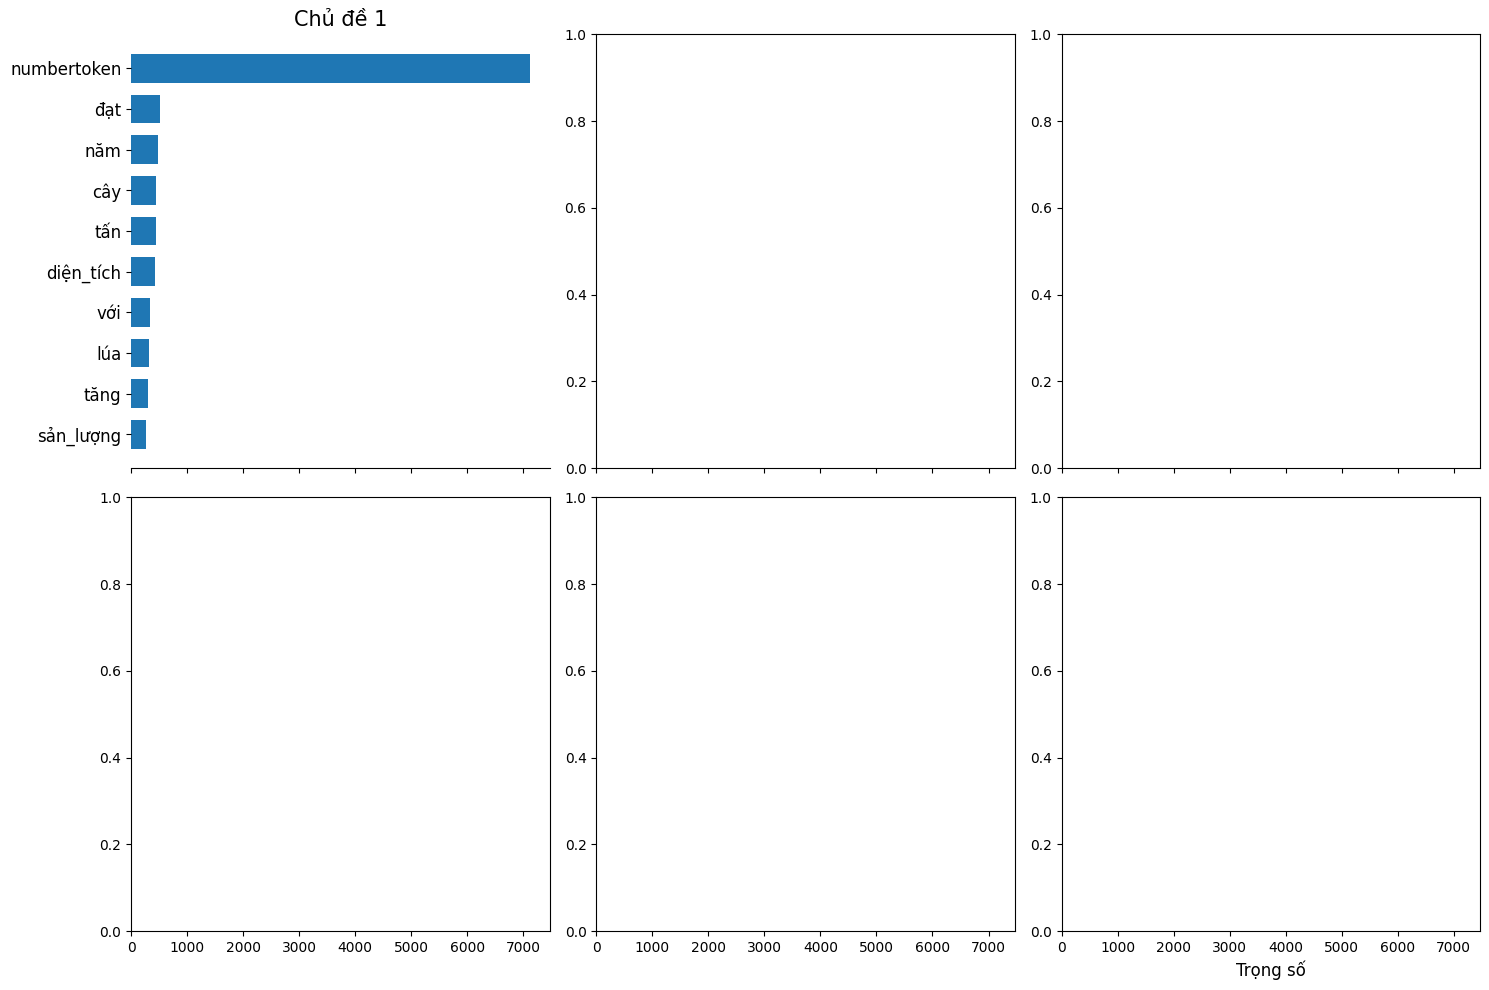

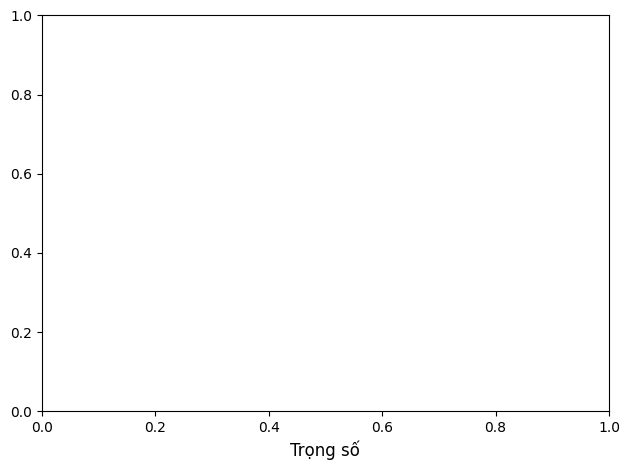

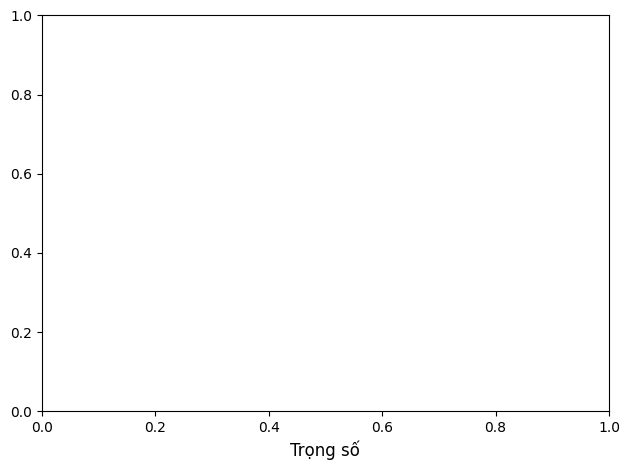

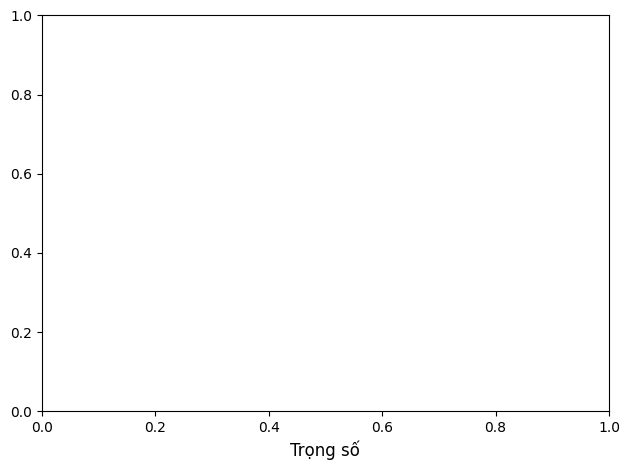

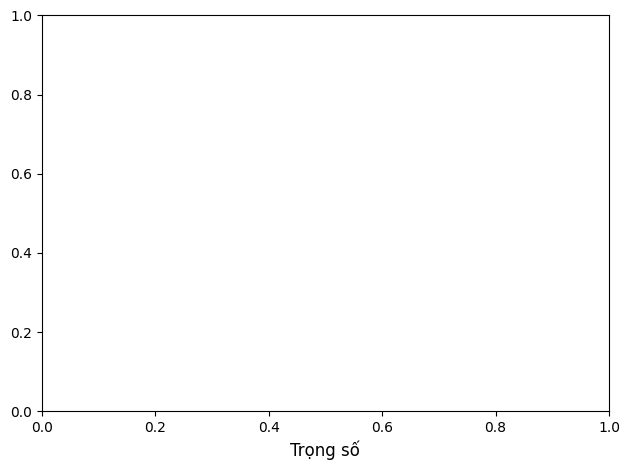

In [22]:
# Trực quan hóa kết quả
def plot_top_words(lda_model, feature_names, n_top_words):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(lda_model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Chủ đề {topic_idx + 1}", fontdict={'fontsize': 15})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=12)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.subplots_adjust(wspace=0.5, hspace=0.5)
        plt.xlabel('Trọng số', fontsize=12)
        plt.tight_layout()
        plt.show()

plot_top_words(lda_model, feature_names, n_top_words)